In [123]:
import re
import pandas as pd
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud


## stopwords

In [124]:
factory = StopWordRemoverFactory()
list_stopword = factory.get_stop_words()
list_stopword.append("nya")
len(list_stopword)

127

In [125]:
conn = sqlite3.connect('dataset\challenge_database.db')
cursor = conn.cursor()
#Membuat stopword_table di db
cursor.execute('''
CREATE TABLE IF NOT EXISTS stopword_table (
    stopword TEXT
    )
''')
for stopword in list_stopword:
    cursor.execute('''
    INSERT INTO stopword_table (stopword) VALUES (?);''', (stopword,))
conn.commit()
conn.close()

In [126]:
conn = sqlite3.connect('dataset\challenge_database.db')
stopword_table = pd.read_sql_query("""
                    SELECT 
                        *
                    FROM stopword_table
                  """, conn)
conn.close()
stopword_table

,stopword
0,yang
1,untuk
2,pada
3,ke
4,para
...,...
122,tentu
123,amat
124,apalagi
125,bagaimanapun


## Data Cleansing

In [127]:
df = pd.read_csv("dataset/train_preprocess.txt", delimiter = "\t", names=["text", "label"])
df.head()

,text,label
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral
2,lokasi strategis di jalan sumatera bandung . t...,positive
3,betapa bahagia nya diri ini saat unboxing pake...,positive
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative


In [128]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11000 entries, 0 to 10999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    11000 non-null  object
 1   label   11000 non-null  object
dtypes: object(2)
memory usage: 172.0+ KB


In [129]:
df.shape

(11000, 2)

In [130]:
df.duplicated().sum()

67

In [131]:
df = df.drop_duplicates()
df

,text,label
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral
2,lokasi strategis di jalan sumatera bandung . t...,positive
3,betapa bahagia nya diri ini saat unboxing pake...,positive
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative
...,...,...
10993,f - demokrat dorong upaya kemandirian energi n...,neutral
10994,tidak bosan,positive
10996,enak rasa masakan nya apalagi kepiting yang me...,positive
10998,"pagi pagi di tol pasteur sudah macet parah , b...",negative


In [132]:
def remove_stopwords(data):
    return " ".join(x for x in data.split() if x not in stopword_table.stopword.values.tolist())

def clean_data(data):
    data = data.lower() #membuat semua huruf menjadi lower case
    data = data.strip() #menghapus white space di awal dan akhir
    data = re.sub('[^a-zA-Z0-9]+', ' ', data) #hapus selain alfanumeric
    data = remove_stopwords(data) #menghapus stopword
    data = data.strip() #menghapus white space di awal dan akhir
    return data

In [133]:
df['text_clean'] = df.text.apply(clean_data)

In [134]:
df.head()

,text,label,text_clean
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive,warung dimiliki pengusaha pabrik tahu puluhan ...
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral,mohon ulama lurus k212 mmbri hujjah partai apa...
2,lokasi strategis di jalan sumatera bandung . t...,positive,lokasi strategis jalan sumatera bandung tempat...
3,betapa bahagia nya diri ini saat unboxing pake...,positive,betapa bahagia diri unboxing paket barang bagu...
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative,duh jadi mahasiswa jangan sombong dong kasih k...


In [135]:
conn = sqlite3.connect('dataset\challenge_database.db')
cursor = conn.cursor()

cursor.execute('''
CREATE TABLE IF NOT EXISTS data_table (
    text TEXT,
    label TEXT,
    text_clean TEXT
)
''')

for index, row in df.iterrows():
    cursor.execute('''
        INSERT INTO data_table VALUES (?, ?, ?)
    ''', tuple(row))

conn.commit()
conn.close()


## Explore Data

C:\Users\imada\AppData\Local\Temp\ipykernel_6956\194933884.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, x='label', palette='mako', order=['positive', 'neutral', 'negative'])


Text(0, 0.5, '')

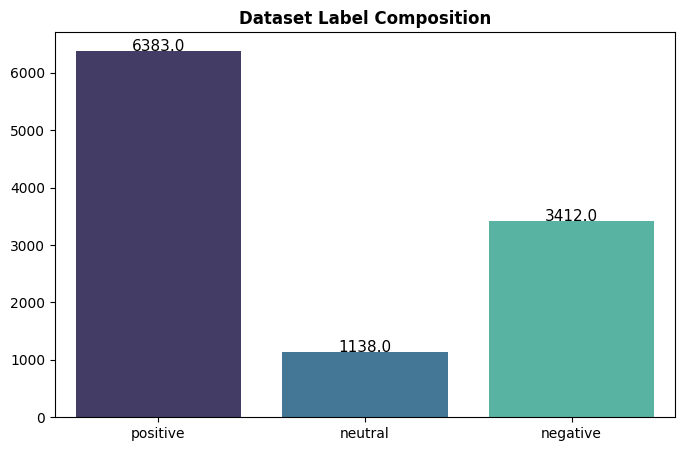

In [136]:
countplt, ax = plt.subplots(figsize = (8,5))
ax = sns.countplot(data=df, x='label', palette='mako', order=['positive', 'neutral', 'negative'])
for rect in ax.patches:
    ax.text (rect.get_x() + rect.get_width()  / 2,rect.get_height()+ 0.75,rect.get_height(),horizontalalignment='center', fontsize = 11)
ax.set_title('Dataset Label Composition',fontsize = 12, fontweight='bold' )
ax.set_xlabel('')
ax.set_ylabel('')

In [137]:
df['total_char'] = df.text.apply(len)
df['total_word'] = df.text.apply(lambda x: len(x.split()))
df['total_char_cleaned'] = df.text_clean.apply(len)
df['total_word_cleaned'] = df.text_clean.apply(lambda x: len(x.split()))

In [138]:
range_total_word = df.total_word.max() - df.total_word.min()
range_total_word

109

In [139]:
range_total_char = df.total_char.max() - df.total_char.min()
range_total_char

564

In [140]:
c0 = df.total_char.min()
c100 = df.total_char.max()

qc1 = df.total_char.quantile(0.25)
qc2 = df.total_char.quantile(0.5)
qc3 = df.total_char.quantile(0.75)

c_iqr = qc3 - qc1

clower_imit = qc1-1.5*c_iqr
cupper_imit = qc3+1.5*c_iqr
print("OUTLIER CHAR")
print("Batas bawah 'total_char':", clower_imit)
print("Nilai minimum", c0)

if (clower_imit < c0):
    print("Tidak ada outlier batas bawah")
else:
    print("Ada outlier di batas bawah")

print("--------------------------------------")

print("Batas atas 'total_char':", cupper_imit)
print("Nilai minimum", c100)

if (cupper_imit > c100):
    print("Tidak ada outlier batas atas")
else:
    print("Ada outlier di batas atas")

OUTLIER CHAR
Batas bawah 'total_char': -186.5
Nilai minimum 3
Tidak ada outlier batas bawah
--------------------------------------
Batas atas 'total_char': 553.5
Nilai minimum 567
Ada outlier di batas atas


In [141]:
w0 = df.total_word.min()
w100 = df.total_word.max()

qw1 = df.total_word.quantile(0.25)
qw2 = df.total_word.quantile(0.5)
qw3 = df.total_word.quantile(0.75)

w_iqr = qw3 - qw1

wlower_imit = qw1-1.5*w_iqr
wupper_imit = qw3+1.5*w_iqr

print("OUTLIER WORD")
print("Batas bawah 'total_word':", wlower_imit)
print("Nilai minimum", w0)

if (wlower_imit < w0):
    print("Tidak ada outlier batas bawah")
else:
    print("Ada outlier di batas bawah")

print("--------------------------------------")

print("Batas atas 'total_word':", wupper_imit)
print("Nilai minimum", w100)

if (wupper_imit > w100):
    print("Tidak ada outlier batas atas")
else:
    print("Ada outlier di batas atas")

OUTLIER WORD
Batas bawah 'total_word': -32.0
Nilai minimum 1
Tidak ada outlier batas bawah
--------------------------------------
Batas atas 'total_word': 96.0
Nilai minimum 110
Ada outlier di batas atas


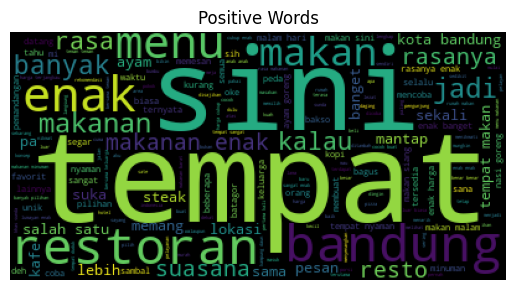

In [142]:
df_positive = df.loc[df['label'] == "positive"]

positive_words = [] 

for tweet in df_positive['text_clean'].str.split():
    for word in tweet:
            positive_words.append(word)

text = ' '.join(positive_words)
wordcloud = WordCloud().generate(text)
plt.title('Positive Words')
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

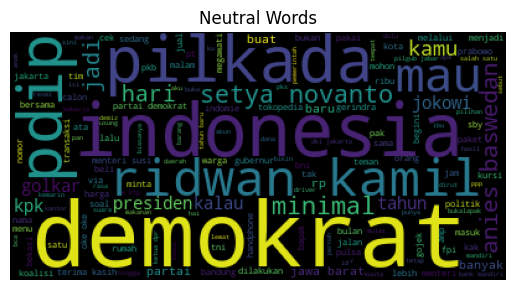

In [143]:
df_neutral = df.loc[df['label'] == "neutral"]

neutral_words = [] 

for tweet in df_neutral['text_clean'].str.split():
    for word in tweet:
            neutral_words.append(word)

text = ' '.join(neutral_words)
wordcloud = WordCloud().generate(text)
plt.title('Neutral Words')
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

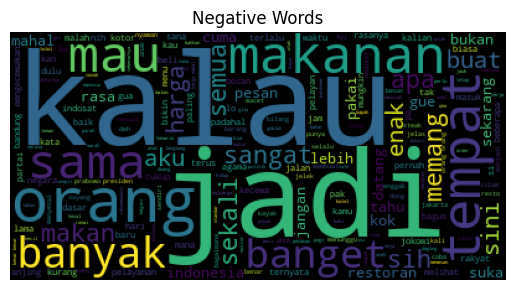

In [144]:
df_negative = df.loc[df['label'] == "negative"]

negative_words = [] 

for tweet in df_negative['text_clean'].str.split():
    for word in tweet:
            negative_words.append(word)

text = ' '.join(negative_words)
wordcloud = WordCloud().generate(text)
plt.title('Negative Words')
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

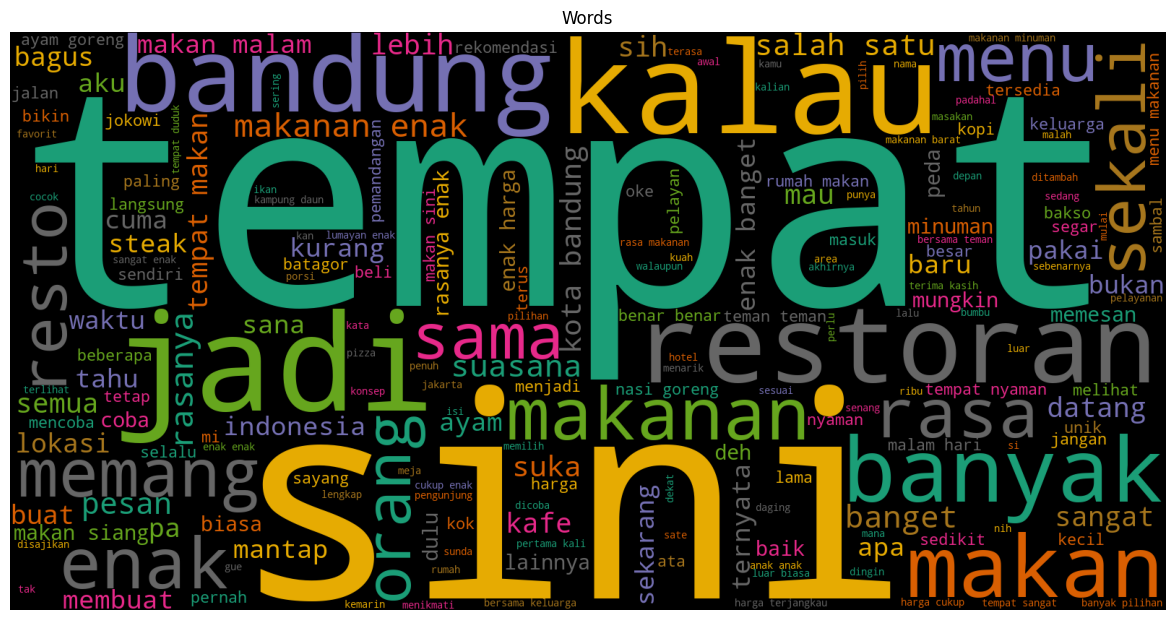

In [145]:
words = [] 

for tweet in df['text_clean'].str.split():
    for word in tweet:
            words.append(word)

text = ' '.join(words)
wordcloud = WordCloud(background_color='black', mode="RGB", width=1600, height=800, colormap="Dark2").generate(text)
plt.figure(figsize=(12, 6))
plt.title('Words')
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

# Feature Extraction

In [146]:
data_preprocessed = df.text_clean.tolist()
data_preprocessed[:10]

['warung dimiliki pengusaha pabrik tahu puluhan tahun terkenal membuat tahu putih bandung tahu berkualitas dipadu keahlian memasak dipadu kretivitas jadilah warung menyajikan menu utama berbahan tahu ditambah menu umum ayam semuanya selera indonesia harga cukup terjangkau jangan lewatkan tahu bletoka kalah asli tegal',
 'mohon ulama lurus k212 mmbri hujjah partai apa diwlh suara islam pecah pecah',
 'lokasi strategis jalan sumatera bandung tempat nyaman terutama sofa lantai 2 paella enak sangat pas dimakan minum bir dingin appetiser enak enak',
 'betapa bahagia diri unboxing paket barang bagus menetapkan beli',
 'duh jadi mahasiswa jangan sombong dong kasih kartu kuning segala belajar dulu baik usahlah ikut ikut politik selesai kuliah mau ikut politik telat dasar mahasiswa',
 'makanan beragam harga makanan food stall ditambahkan 10 kasir suasana ramai perlu perhatian mendapatkan parkir tempat duduk',
 'pakai kartu kredit bca untung malah rugi besar',
 'tempat unik bagus buat foto makan

In [147]:
from sklearn.model_selection import train_test_split

X = df["text_clean"]
Y = df["label"]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, stratify=Y)

## Future Extraction for NN using BoW

In [148]:
from sklearn.feature_extraction.text import CountVectorizer
import pickle

# Kita proses Feature Extraction
count_vect = CountVectorizer()
count_vect.fit(data_preprocessed)

# Fit dan transform data training
X_train_counts = count_vect.transform(X_train)

# Transform data test
X_test_counts = count_vect.transform(X_test)

# Simpan CountVectorizer dan data yang telah ditransformasi
with open('Extraction File/NN/fe_nn.p', 'wb') as f:
    pickle.dump(count_vect, f)
with open('Extraction File/NN/X_train_counts.pkl', 'wb') as f:
    pickle.dump(X_train_counts, f)
with open('Extraction File/NN/X_test_counts.pkl', 'wb') as f:
    pickle.dump(X_test_counts, f)
with open('Extraction File/NN/y_train.pkl', 'wb') as f:
    pickle.dump(y_train, f)
with open('Extraction File/NN/y_test.pkl', 'wb') as f:
    pickle.dump(y_test, f)

## Future Extraction for LSTM using Tokenizer & pad_sequences

In [149]:
neg = df.loc[df['label'] == 'negative'].text_clean.tolist()
neu = df.loc[df['label'] == 'neutral'].text_clean.tolist()
pos = df.loc[df['label'] == 'positive'].text_clean.tolist()

neg_label = df.loc[df['label'] == 'negative'].label.tolist()
neu_label = df.loc[df['label'] == 'neutral'].label.tolist()
pos_label = df.loc[df['label'] == 'positive'].label.tolist()

In [150]:
total_data = pos + neu + neg
labels = pos_label + neu_label + neg_label

print("Pos: %s, Neu: %s, Neg: %s" % (len(pos), len(neu), len(neg)))
print("Total data: %s" % len(total_data))

Pos: 6383, Neu: 1138, Neg: 3412
Total data: 10933


In [151]:
import pickle
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import defaultdict

max_features = 100000
tokenizer = Tokenizer(num_words=max_features, split=' ')

tokenizer.fit_on_texts(total_data)

with open('Extraction File/LSTM/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print("Extraction File/LSTM/tokenizer.pickle has created!")

# Transform data training dan test
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

# Padding sequences
X_train_padded = pad_sequences(X_train_sequences, padding='post')
X_test_padded = pad_sequences(X_test_sequences, padding='post')

with open('Extraction File/LSTM/X_train_padded.pickle', 'wb') as f:
    pickle.dump(X_train_padded, f, protocol=pickle.HIGHEST_PROTOCOL)
    print("Extraction File/LSTM/X_train_padded.pickle has created!")
with open('Extraction File/LSTM/X_test_padded.pickle', 'wb') as f:
    pickle.dump(X_test_padded, f, protocol=pickle.HIGHEST_PROTOCOL)
    print("Extraction File/LSTM/X_test_padded.pickle has created!")

Extraction File/LSTM/tokenizer.pickle has created!
Extraction File/LSTM/X_train_padded.pickle has created!
Extraction File/LSTM/X_test_padded.pickle has created!


In [152]:
y_train_dummies = pd.get_dummies(y_train)
y_train_dummies = y_train_dummies.values
y_test_dummies = pd.get_dummies(y_test)
y_test_dummies = y_test_dummies.values
# Y = Y.values

with open('Extraction File/LSTM/y_train.pickle', 'wb') as f:
    pickle.dump(y_train_dummies, f, protocol=pickle.HIGHEST_PROTOCOL)
    print("Extraction File/LSTM/y_train.pickle has created!")
with open('Extraction File/LSTM/y_test.pickle', 'wb') as f:
    pickle.dump(y_test_dummies, f, protocol=pickle.HIGHEST_PROTOCOL)
    print("Extraction File/LSTM/y_test.pkl has created!")

Extraction File/LSTM/y_train.pickle has created!
Extraction File/LSTM/y_test.pkl has created!
